In [1]:
# Only run this code when duplicates exist
import shutil
import os

# Define the main working directory for the dataset
DATASET_ROOT = 'waste_data'

print(f"--- Deleting entire dataset folder: {DATASET_ROOT} ---")

if os.path.exists(DATASET_ROOT):
    # shutil.rmtree recursively deletes the folder and all its contents
    shutil.rmtree(DATASET_ROOT)
    print(f"✅ Successfully deleted the existing {DATASET_ROOT} directory.")
else:
    print(f"⏩ {DATASET_ROOT} not found. Safe to proceed.")

# You must rerun the Kaggle download/unzip cell immediately after this!

--- Deleting entire dataset folder: waste_data ---
✅ Successfully deleted the existing waste_data directory.


In [2]:
!pip install kaggle

!pip install tensorflow keras numpy matplotlib

In [7]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.19.0
GPU available: []


In [8]:
import os

os.environ['KAGGLE_KEY'] = 'KGAT_eeac56217f1a76da17a73a9be206a0b0'
os.environ['KAGGLE_USERNAME'] = 'hexel_rana'

In [9]:
!kaggle datasets download -d sapal6/waste-classification-data-v2

Dataset URL: https://www.kaggle.com/datasets/sapal6/waste-classification-data-v2
License(s): CC-BY-SA-4.0
 54% 123M/226M [00:00<00:00, 1.28GB/s]
100% 226M/226M [00:00<00:00, 696MB/s] 


In [10]:
!unzip waste-classification-data-v2.zip -d waste_data

Streaming output truncated to the last 5000 lines.
  inflating: waste_data/DATASET/TRAIN/R/R_5000.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5001.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5002.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5003.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5004.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5005.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5006.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5007.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5008.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5009.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5010.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5011.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5012.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5013.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5014.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5015.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5016.jpg  
  inflating: waste_data/DATASET/TRAIN/R/R_5017.j

In [11]:
DATA_ROOT = 'waste_data/DATASET'

!mv {DATA_ROOT}/TRAIN/O {DATA_ROOT}/TRAIN/Biodegradable
!mv {DATA_ROOT}/TEST/O {DATA_ROOT}/TEST/Biodegradable

!mv {DATA_ROOT}/TRAIN/R {DATA_ROOT}/TRAIN/Recyclable
!mv {DATA_ROOT}/TEST/R {DATA_ROOT}/TEST/Recyclable

!mv {DATA_ROOT}/TRAIN/N {DATA_ROOT}/TRAIN/Non-Biodegradable
!mv {DATA_ROOT}/TEST/N {DATA_ROOT}/TEST/Non-Biodegradable

print("Folders successfully renamed to Biodegradable, Recyclable, and Non-Biodegradable.")

Folders successfully renamed to Biodegradable, Recyclable, and Non-Biodegradable.


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = 3

TRAIN_PATH = 'waste_data/DATASET/TRAIN'
TEST_PATH = 'waste_data/DATASET/TEST'


train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


validation_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 22564 images belonging to 3 classes.
Found 2907 images belonging to 3 classes.


In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)



for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,572,803 (13.63 MB)

 Trainable params: 1,314,819 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import math
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'best_weights_3class.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

EPOCHS = 10
BATCH_SIZE = 64

STEPS_PER_EPOCH = math.ceil(train_generator.samples / BATCH_SIZE)
VALIDATION_STEPS = math.ceil(validation_generator.samples / BATCH_SIZE)

print(f"Starting 3-class training with BATCH_SIZE={BATCH_SIZE} and {STEPS_PER_EPOCH} steps.")

history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[model_checkpoint_callback]
)

Starting 3-class training with BATCH_SIZE=64 and 353 steps.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 1288s 4s/step - accuracy: 0.7672 - loss: 0.5668 - val_accuracy: 0.7393 - val_loss: 0.5972
Epoch 2/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 1281s 4s/step - accuracy: 0.8844 - loss: 0.3131 - val_accuracy: 0.7939 - val_loss: 0.4991
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 1288s 4s/step - accuracy: 0.9029 - loss: 0.2639 - val_accuracy: 0.8111 - val_loss: 0.4843
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 1276s 4s/step - accuracy: 0.9128 - loss: 0.2368 - val_accuracy: 0.7771 - val_loss: 0.5394
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 1306s 4s/step - accuracy: 0.9142 - loss: 0.2235 - val_accuracy: 0.7988 - val_loss: 0.5132
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 1323s 4s/step - accuracy: 0.9253 - loss: 0.2004 - val_accuracy: 0.7895 - val_loss: 0.5434
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 1348s 4s/step - accuracy: 0.9285 - loss: 0.1927 - val_accuracy: 0.7430 - val_loss: 0.6313
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 1323s 4s/step - accuracy: 0.9368 - loss: 0.1765 - 

In [38]:
print("Evaluating model on the test set...")

loss, accuracy = model.evaluate(validation_generator)

print(f"\n--- Final Model Performance ---")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model on the test set...
46/46 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.9223 - loss: 0.2249

--- Final Model Performance ---
Test Loss: 0.7363
Test Accuracy: 0.7530


In [ ]:
MODEL_NAME = 'waste_classifier_mobilenet_v2.h5'
model.save(MODEL_NAME)

print(f"\nModel successfully saved as {MODEL_NAME}")

In [35]:
MODEL_NAME_NATIVE = 'waste_classifier_mobilenet_v2.keras'
model.save(MODEL_NAME_NATIVE)

print(f"\nModel successfully saved as {MODEL_NAME_NATIVE}")


Model successfully saved as waste_classifier_mobilenet_v2.keras


In [43]:
base_model.trainable = True

print(f"Total layers in MobileNetV2: {len(base_model.layers)}")
FINE_TUNE_AT = 50
for layer in base_model.layers[:-FINE_TUNE_AT]:
    layer.trainable = False

print(f"Number of layers being fine-tuned (Trainable): {len(base_model.trainable_weights)}")

Total layers in MobileNetV2: 154
Number of layers being fine-tuned (Trainable): 51


In [42]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model re-compiled for fine-tuning...")

Model re-compiled for fine-tuning...


In [13]:
import math

FINE_TUNE_EPOCHS = 5
EPOCHS = FINE_TUNE_EPOCHS
BATCH_SIZE = 64


STEPS_PER_EPOCH = math.ceil(train_generator.samples / BATCH_SIZE)
VALIDATION_STEPS = math.ceil(validation_generator.samples / BATCH_SIZE)

checkpoint_filepath_ft = 'best_weights_3class_finetuned.weights.h5'
model_checkpoint_callback_ft = ModelCheckpoint(
    filepath=checkpoint_filepath_ft,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)


history_fine = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,

    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[model_checkpoint_callback_ft],
)

NameError: name 'ModelCheckpoint' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_types = [tf.float16]

tflite_quant_model_f16 = converter.convert()

TFLITE_MODEL_NAME_F16 = 'waste_classifier_f16.tflite'
with open(TFLITE_MODEL_NAME_F16, 'wb') as f:
    f.write(tflite_quant_model_f16)

print(f"\n16-bit Quantized model saved as {TFLITE_MODEL_NAME_F16}. Estimated size: ~12.1 MB")

In [ ]:
import tensorflow as tf
import keras

print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

try:
    model.load_weights('path/to/your_model_weights.h5')
except Exception as e:
    print(f"Error loading weights: {e}. Make sure the file path is correct.")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'waste_data/DATASET/TRAIN',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(test_generator.class_indices.keys())

Error loading weights: [Errno 2] Unable to synchronously open file (unable to open file: name = 'path/to/your_model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Make sure the file path is correct.
Found 22564 images belonging to 3 classes.


In [41]:
import numpy as np

validation_generator.reset()

Y_pred_probabilities = model.predict(validation_generator, steps=VALIDATION_STEPS)
Y_pred = np.argmax(Y_pred_probabilities, axis=1)
Y_true = validation_generator.classes

print(f"Generated {len(Y_pred)} predictions and found {len(Y_true)} true labels.")

46/46 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step
Generated 2907 predictions and found 2907 true labels.


In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd


class_labels = list(validation_generator.class_indices.keys())

conf_matrix = confusion_matrix(Y_true, Y_pred)

print("\n--- Confusion Matrix ---")

cm_df = pd.DataFrame(conf_matrix,
                     index = class_labels,
                     columns = class_labels)
print(cm_df)

# Classification Report
# F1-Score, Precision, and Recall for all classes.
report = classification_report(Y_true, Y_pred, target_names=class_labels)

print("\n--- Classification Report (F1-Score, Precision, Recall) ---")
print(report)


--- Confusion Matrix ---
                   Biodegradable  Non-Biodegradable  Recyclable
Biodegradable                 74                319        1008
Non-Biodegradable             81                103         210
Recyclable                   112                233         767

--- Classification Report (F1-Score, Precision, Recall) ---
                   precision    recall  f1-score   support

    Biodegradable       0.28      0.05      0.09      1401
Non-Biodegradable       0.16      0.26      0.20       394
       Recyclable       0.39      0.69      0.50      1112

         accuracy                           0.32      2907
        macro avg       0.27      0.33      0.26      2907
     weighted avg       0.30      0.32      0.26      2907



In [33]:
MODEL_NAME_NATIVE = 'waste_classifier_finetuned_3class.keras'
model.save(MODEL_NAME_NATIVE)

print(f"✅ Final Keras model saved as {MODEL_NAME_NATIVE}")

✅ Final Keras model saved as waste_classifier_finetuned_3class.keras


In [34]:
import tensorflow as tf
import os

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

MODEL_NAME_TFLITE = 'waste_classifier_final_quantized.tflite'
with open(MODEL_NAME_TFLITE, 'wb') as f:
    f.write(tflite_model)

size_bytes = os.path.getsize(MODEL_NAME_TFLITE)
size_mb = size_bytes / (1024 * 1024)

print(f"\n✅ TFLite model successfully created: {MODEL_NAME_TFLITE}")
print(f"File size: {size_mb:.2f} MB")

Saved artifact at '/tmp/tmpm2klmkc5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140032137565328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140032137566864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140032137566672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140032137566096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140032137567440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140032137565520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140032137567056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140032137567248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140032137566288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140032137568400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1400321375

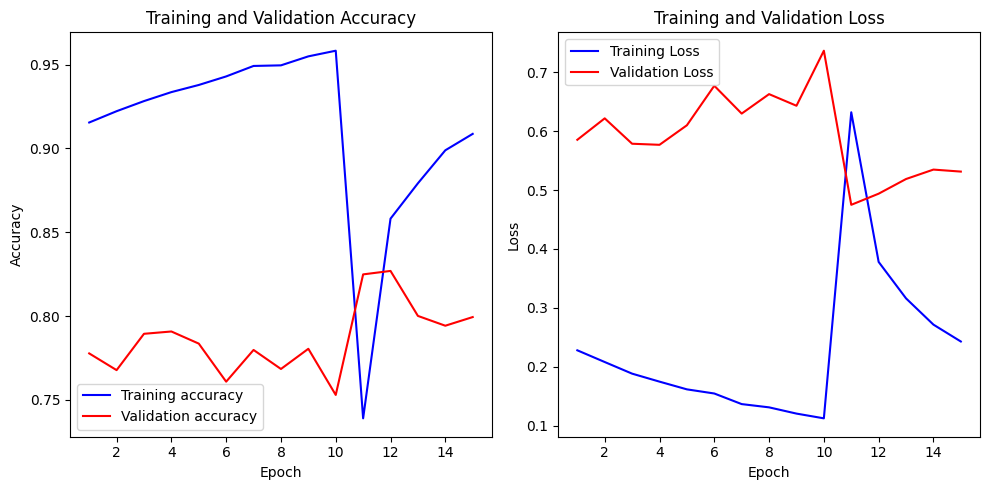


--- Final Epoch Data ---
Final Training Accuracy: 0.9087
Final Validation Accuracy: 0.7994
Final Training Loss: 0.2430
Final Validation Loss: 0.5312


In [39]:
import matplotlib.pyplot as plt
import numpy as np

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) # Plot 1: Accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2) # Plot 2: Loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("\n--- Final Epoch Data ---")
print(f"Final Training Accuracy: {acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
print(f"Final Training Loss: {loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")